# GenAI-A1

In [1]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch CUDA Version: {torch.backends.cudnn.version()}")
else:
    print("No GPU found!")

GPU Available: NVIDIA RTX A4000
CUDA Version: 12.4
PyTorch CUDA Version: 90100


## PART-1

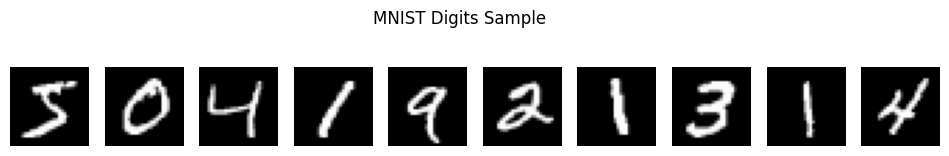

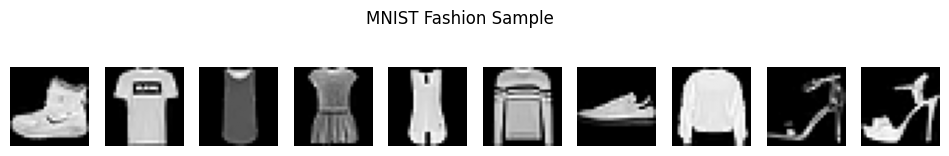

MNIST Digits - Total Samples: 60000, Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
MNIST Fashion - Total Samples: 60000, Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load MNIST Digits
mnist_digits = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Load MNIST Fashion
mnist_fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Function to visualize images
def show_samples(dataset, title, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

# Display some samples
show_samples(mnist_digits, "MNIST Digits Sample")
show_samples(mnist_fashion, "MNIST Fashion Sample")

# Dataset Information
print(f"MNIST Digits - Total Samples: {len(mnist_digits)}, Classes: {set(mnist_digits.targets.numpy())}")
print(f"MNIST Fashion - Total Samples: {len(mnist_fashion)}, Classes: {set(mnist_fashion.targets.numpy())}")

## PART-2

### GANS for MNIST_DIGITS

Using device: cuda
Epoch [1/50] | D Loss: 0.9368 | G Loss: 1.2275
Epoch [2/50] | D Loss: 1.1551 | G Loss: 0.6717
Epoch [3/50] | D Loss: 1.2527 | G Loss: 1.3990
Epoch [4/50] | D Loss: 1.2737 | G Loss: 0.6812
Epoch [5/50] | D Loss: 1.2518 | G Loss: 0.8767
Epoch [6/50] | D Loss: 1.2632 | G Loss: 0.5789
Epoch [7/50] | D Loss: 1.2468 | G Loss: 0.5982
Epoch [8/50] | D Loss: 1.1551 | G Loss: 0.9164
Epoch [9/50] | D Loss: 0.6538 | G Loss: 1.5077
Epoch [10/50] | D Loss: 0.8422 | G Loss: 1.9617
Epoch [11/50] | D Loss: 0.1190 | G Loss: 3.5394
Epoch [12/50] | D Loss: 0.0784 | G Loss: 3.5238
Epoch [13/50] | D Loss: 0.0535 | G Loss: 4.0731
Epoch [14/50] | D Loss: 0.5124 | G Loss: 2.6811
Epoch [15/50] | D Loss: 0.0563 | G Loss: 4.1205
Epoch [16/50] | D Loss: 0.7906 | G Loss: 2.9702
Epoch [17/50] | D Loss: 0.0265 | G Loss: 5.0559
Epoch [18/50] | D Loss: 0.0362 | G Loss: 4.8584
Epoch [19/50] | D Loss: 0.0139 | G Loss: 5.6582
Epoch [20/50] | D Loss: 0.5033 | G Loss: 1.9103
Epoch [21/50] | D Loss: 0.0323

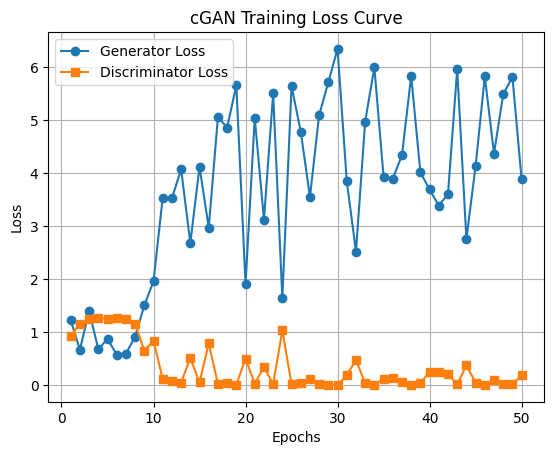

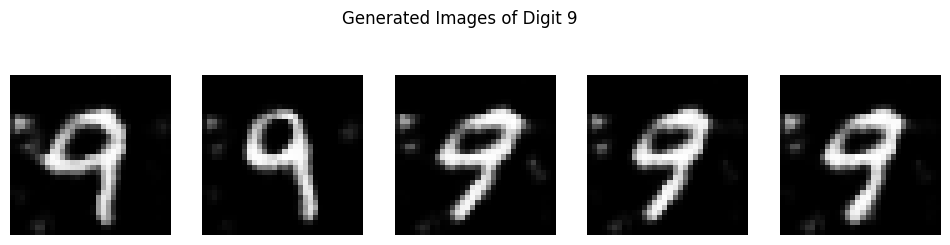

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
batch_size = 128
lr = 0.0002
latent_dim = 100
epochs = 50
num_classes = 10  # Digits 0-9
embedding_dim = 10  # Label embedding

# Data Loading
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Custom Weight Initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim + embedding_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embed = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        input = torch.cat((z, label_embed), dim=1)
        return self.model(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Conv2d(1 + embedding_dim, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embed = self.label_embedding(labels).unsqueeze(2).unsqueeze(3).expand(-1, -1, 32, 32)
        input = torch.cat((img, label_embed), dim=1)
        return self.model(input).view(-1, 1)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Custom BCE Loss Functions from Hints
def discriminator_loss(D_real, D_fake):
    return -torch.mean(torch.log(D_real + 1e-8) + torch.log(1 - D_fake + 1e-8))

def generator_loss(D_fake):
    return -torch.mean(torch.log(D_fake + 1e-8))

# Training Loop
G_losses, D_losses = [], []
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(dataloader):
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = generator(z, labels)

        D_real = discriminator(real_imgs, labels)
        D_fake = discriminator(fake_imgs.detach(), labels)
        
        D_loss = discriminator_loss(D_real, D_fake)
        D_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        D_fake = discriminator(fake_imgs, labels)
        G_loss = generator_loss(D_fake)
        G_loss.backward()
        optimizer_G.step()

    # Store losses
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

# Plot Loss vs Epoch Curve
plt.plot(range(1, epochs+1), G_losses, label="Generator Loss", marker="o")
plt.plot(range(1, epochs+1), D_losses, label="Discriminator Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("cGAN Training Loss Curve")
plt.grid()
plt.show()

# Generate 5 Samples of Digit "9"
num_samples = 5
z = torch.randn(num_samples, latent_dim, 1, 1, device=device)
labels = torch.full((num_samples,), 9, device=device)  # Generate only "9"

fake_imgs = generator(z, labels).cpu().detach()
fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(fake_imgs[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Images of Digit 9")
plt.show()

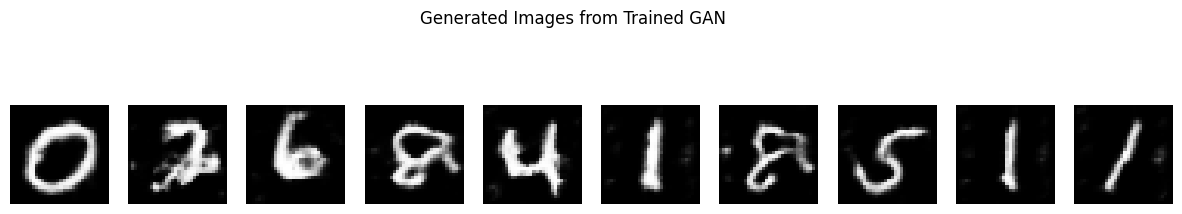

In [4]:
# Generate 10 random samples
num_samples = 10
z = torch.randn(num_samples, latent_dim, 1, 1, device=device)
labels = torch.randint(0, 10, (num_samples,), device=device)  

# Generate images
fake_imgs = generator(z, labels).cpu().detach()

# Display generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(fake_imgs[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Images from Trained GAN")
plt.show()


### GANs for MINST_FASHION

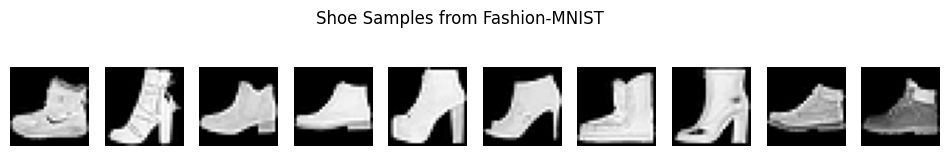

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

# Load Fashion-MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_mnist = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

# Select only "Shoe" class (label 9)
shoe_indices = [i for i in range(len(fashion_mnist)) if fashion_mnist.targets[i] == 9]
shoe_dataset = Subset(fashion_mnist, shoe_indices)
shoe_loader = DataLoader(shoe_dataset, batch_size=64, shuffle=True)

# Show some shoe samples
def show_shoes(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 2))
    for i in range(num_images):
        img, _ = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Shoe Samples from Fashion-MNIST")
    plt.show()

show_shoes(shoe_dataset)


In [6]:
class ShoeGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super(ShoeGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [7]:
class ShoeDiscriminator(nn.Module):
    def __init__(self):
        super(ShoeDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)


In [8]:
# Initialize models
latent_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = ShoeGenerator(latent_dim).to(device)
discriminator = ShoeDiscriminator().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training loop
epochs = 50
losses_G, losses_D = [], []

for epoch in range(epochs):
    for real_imgs, _ in shoe_loader:
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)

        real_loss = criterion(discriminator(real_imgs), real_labels)

        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)
        fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    losses_G.append(g_loss.item())
    losses_D.append(d_loss.item())

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Save models
torch.save(generator.state_dict(), "shoe_generator.pth")
torch.save(discriminator.state_dict(), "shoe_discriminator.pth")

Epoch 1/50 | D Loss: 0.6170 | G Loss: 3.1586
Epoch 2/50 | D Loss: 0.4720 | G Loss: 1.5220
Epoch 3/50 | D Loss: 0.6164 | G Loss: 2.5854
Epoch 4/50 | D Loss: 0.6926 | G Loss: 1.5761
Epoch 5/50 | D Loss: 0.6315 | G Loss: 1.4209
Epoch 6/50 | D Loss: 0.8720 | G Loss: 1.1961
Epoch 7/50 | D Loss: 1.0058 | G Loss: 0.8403
Epoch 8/50 | D Loss: 0.8036 | G Loss: 1.7366
Epoch 9/50 | D Loss: 0.7672 | G Loss: 1.3833
Epoch 10/50 | D Loss: 0.7620 | G Loss: 1.6763
Epoch 11/50 | D Loss: 0.8968 | G Loss: 1.1470
Epoch 12/50 | D Loss: 0.8192 | G Loss: 1.2899
Epoch 13/50 | D Loss: 0.8015 | G Loss: 1.5606
Epoch 14/50 | D Loss: 0.8490 | G Loss: 1.6668
Epoch 15/50 | D Loss: 0.7855 | G Loss: 1.3306
Epoch 16/50 | D Loss: 0.8598 | G Loss: 1.3463
Epoch 17/50 | D Loss: 0.8344 | G Loss: 1.2260
Epoch 18/50 | D Loss: 0.9019 | G Loss: 1.2560
Epoch 19/50 | D Loss: 1.0193 | G Loss: 0.9379
Epoch 20/50 | D Loss: 1.0014 | G Loss: 0.9586
Epoch 21/50 | D Loss: 0.8975 | G Loss: 1.7272
Epoch 22/50 | D Loss: 1.0643 | G Loss: 1.61

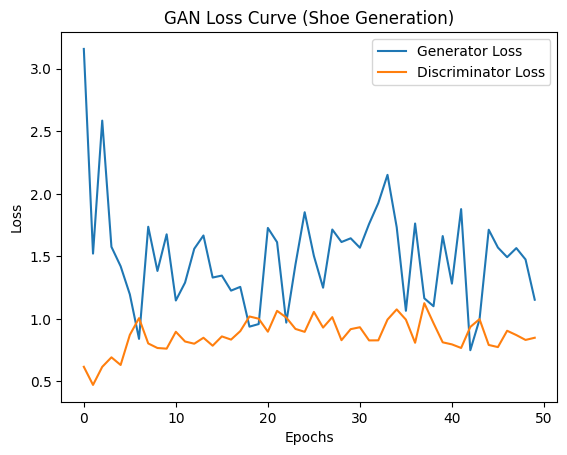

In [9]:
plt.plot(losses_G, label="Generator Loss")
plt.plot(losses_D, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Loss Curve (Shoe Generation)")
plt.show()


/tmp/ipykernel_1536882/141177060.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("shoe_generator.pth"))


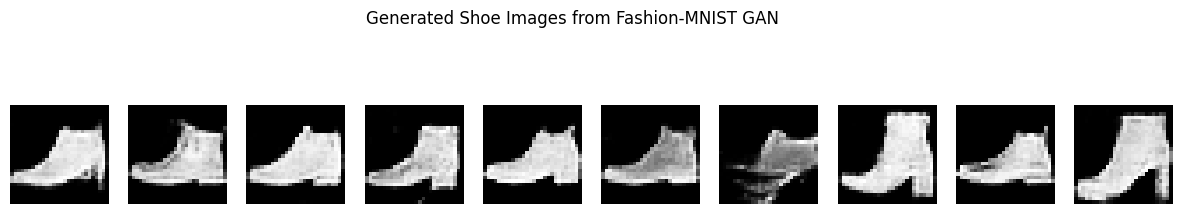

In [10]:
# Load trained Generator
generator = ShoeGenerator(latent_dim).to(device)
generator.load_state_dict(torch.load("shoe_generator.pth"))
generator.eval()

# Generate 10 new images of shoes
num_samples = 10
z = torch.randn(num_samples, latent_dim, 1, 1, device=device)

with torch.no_grad():
    fake_shoes = generator(z).cpu()

# Display generated shoe images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(fake_shoes[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Shoe Images from Fashion-MNIST GAN")
plt.show()


## PART-3

### VAE for MNIST_DIGITS

In [11]:
!pip install scikit-learn

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 64*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder_fc(z).view(-1, 64, 7, 7)
        x_recon = self.decoder(x_recon)
        return x_recon, mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Load Dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Train Model
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

def train_vae(epochs=10):
    vae.train()
    for epoch in range(epochs):
        train_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = vae(x)
            loss = loss_function(recon_x, x, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {train_loss/len(dataloader.dataset):.4f}')

train_vae(100)


Epoch 1, Loss: 158.5636
Epoch 2, Loss: 115.8905
Epoch 3, Loss: 110.8299
Epoch 4, Loss: 108.4401
Epoch 5, Loss: 106.9213
Epoch 6, Loss: 105.8885
Epoch 7, Loss: 105.1077
Epoch 8, Loss: 104.4797
Epoch 9, Loss: 103.9344
Epoch 10, Loss: 103.4644
Epoch 11, Loss: 103.1066
Epoch 12, Loss: 102.7675
Epoch 13, Loss: 102.4626
Epoch 14, Loss: 102.2158
Epoch 15, Loss: 102.0098
Epoch 16, Loss: 101.7717
Epoch 17, Loss: 101.5759
Epoch 18, Loss: 101.3639
Epoch 19, Loss: 101.2207
Epoch 20, Loss: 101.0513
Epoch 21, Loss: 100.8992
Epoch 22, Loss: 100.7325
Epoch 23, Loss: 100.6608
Epoch 24, Loss: 100.5208
Epoch 25, Loss: 100.4140
Epoch 26, Loss: 100.2972
Epoch 27, Loss: 100.1992
Epoch 28, Loss: 100.0618
Epoch 29, Loss: 100.0059
Epoch 30, Loss: 99.9259
Epoch 31, Loss: 99.8173
Epoch 32, Loss: 99.7400
Epoch 33, Loss: 99.7168
Epoch 34, Loss: 99.6206
Epoch 35, Loss: 99.5659
Epoch 36, Loss: 99.4376
Epoch 37, Loss: 99.4209
Epoch 38, Loss: 99.3587
Epoch 39, Loss: 99.2726
Epoch 40, Loss: 99.2149
Epoch 41, Loss: 99.1

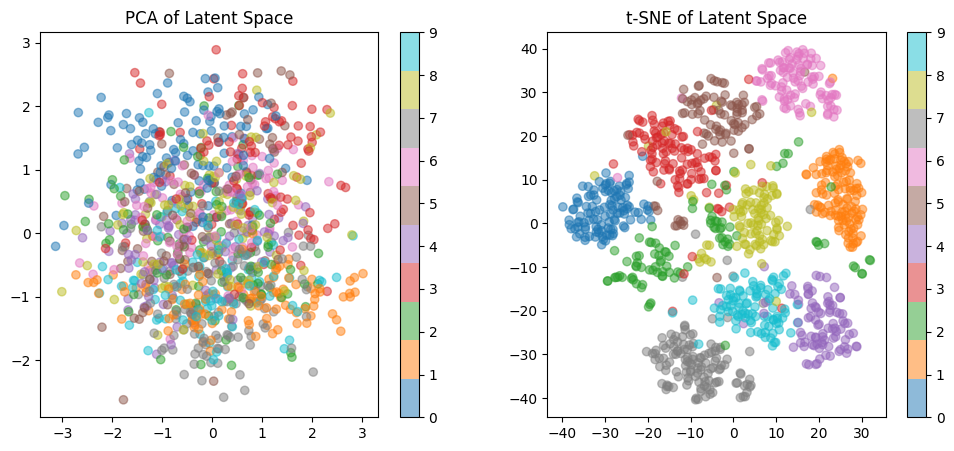

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(vae, dataloader, num_samples=1000):
    vae.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            _, mu, _ = vae(x)
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(y.numpy())
            if len(latent_vectors) * len(x) >= num_samples:
                break

    latent_vectors = np.vstack(latent_vectors)
    
    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(latent_vectors)
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title("PCA of Latent Space")

    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar()
    plt.title("t-SNE of Latent Space")

    plt.show()

# Call function for MNIST
visualize_latent_space(vae, dataloader)


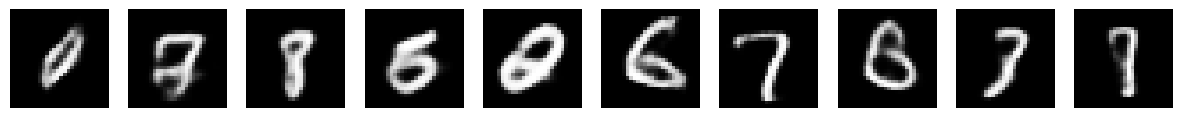

In [14]:
def generate_new_images(vae, num_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, vae.latent_dim).to(device)
        generated = vae.decoder_fc(z).view(-1, 64, 7, 7)
        generated = vae.decoder(generated).cpu()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

generate_new_images(vae, 10)


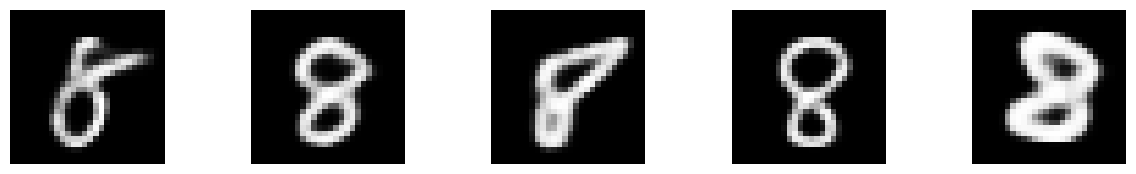

In [15]:
# Function to get latent vectors of a specific digit
def get_latent_vectors(vae, dataloader, digit, num_samples=5):
    vae.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for x, y in dataloader:
            mask = (y == digit)
            x_filtered = x[mask]
            if len(x_filtered) == 0:
                continue
            x_filtered = x_filtered.to(device)
            _, mu, _ = vae(x_filtered)
            latent_vectors.append(mu.cpu().numpy())
            if len(latent_vectors) * len(x_filtered) >= num_samples:
                break

    return np.vstack(latent_vectors)

def generate_specific_digit(vae, digit, num_samples=5):
    latent_vectors = get_latent_vectors(vae, dataloader, digit, num_samples)
    latent_vectors = torch.tensor(latent_vectors, dtype=torch.float32).to(device)
    
    vae.eval()
    with torch.no_grad():
        generated = vae.decoder_fc(latent_vectors).view(-1, 64, 7, 7)
        generated = vae.decoder(generated).cpu()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

generate_specific_digit(vae, 8, 5)


### VAE For MNIST_FASHION

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10
import os
import pickle
import zipfile
import datetime

class EncoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel, padding=pad, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EncoderModule(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EncoderModule(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EncoderModule(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EncoderModule(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)
        
class DecoderModule(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        self.convt = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=stride, stride=stride)
        self.bn = nn.BatchNorm2d(output_channels)
        if activation == "relu":
            self.activation = nn.ReLU(inplace=True)
        elif activation == "sigmoid":
            self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderModule(256, 128, stride=1)
        self.m2 = DecoderModule(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderModule(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderModule(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

class VAE(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        assert dataset in ["mnist", "fashion-mnist", "cifar", "stl"]
        self.n_latent_features = 64
        if dataset in ["mnist", "fashion-mnist"]:
            pooling_kernel = [2, 2]
            encoder_output_size = 7
        elif dataset == "cifar":
            pooling_kernel = [4, 2]
            encoder_output_size = 4
        elif dataset == "stl":
            pooling_kernel = [4, 4]
            encoder_output_size = 6
        color_channels = 1 if dataset in ["mnist", "fashion-mnist"] else 3
        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc3 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)
        self.train_loader, self.test_loader = self.load_data(dataset)
        self.history = {"loss":[], "val_loss":[]}
        self.model_name = dataset
        os.makedirs(self.model_name, exist_ok=True)

    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(self.device)
        z = mu + std * esp
        return z
    
    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar
        
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self._bottleneck(h)
        z = self.fc3(z)
        d = self.decoder(z)
        return d, mu, logvar

    def load_data(self, dataset):
        transform = transforms.Compose([transforms.ToTensor()])
        datasets = {
            "mnist": MNIST,
            "fashion-mnist": FashionMNIST,
        }
        train = datasets[dataset](root="./data", train=True, transform=transform, download=True)
        test = datasets[dataset](root="./data", train=False, transform=transform, download=True)
        train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=4)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=4)
        return train_loader, test_loader

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def train_model(self, epochs=1):
        self.to(self.device)
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        for epoch in range(epochs):
            self.train()
            train_loss = 0
            for inputs, _ in self.train_loader:
                inputs = inputs.to(self.device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = self(inputs)
                loss = self.loss_function(recon_batch, inputs, mu, logvar)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            print(f"Epoch {epoch+1}, Loss: {train_loss / len(self.train_loader.dataset):.4f}")

def main():
    vae = VAE("fashion-mnist")
    vae.train_model(epochs=100)

if __name__ == "__main__":
    main()

Epoch 1, Loss: 381.3574
Epoch 2, Loss: 307.8830
Epoch 3, Loss: 281.1042
Epoch 4, Loss: 267.0299
Epoch 5, Loss: 258.4462
Epoch 6, Loss: 253.3282
Epoch 7, Loss: 249.8088
Epoch 8, Loss: 247.3726
Epoch 9, Loss: 245.6543
Epoch 10, Loss: 244.4598
Epoch 11, Loss: 243.3834
Epoch 12, Loss: 242.6451
Epoch 13, Loss: 241.9708
Epoch 14, Loss: 241.5040
Epoch 15, Loss: 241.0795
Epoch 16, Loss: 240.7284
Epoch 17, Loss: 240.3908
Epoch 18, Loss: 240.1526
Epoch 19, Loss: 239.9055
Epoch 20, Loss: 239.7324
Epoch 21, Loss: 239.5756
Epoch 22, Loss: 239.3751
Epoch 23, Loss: 239.2441
Epoch 24, Loss: 239.0877
Epoch 25, Loss: 238.9312
Epoch 26, Loss: 238.8354
Epoch 27, Loss: 238.6517
Epoch 28, Loss: 238.6530
Epoch 29, Loss: 238.5454
Epoch 30, Loss: 238.4224
Epoch 31, Loss: 238.3039
Epoch 32, Loss: 238.1971
Epoch 33, Loss: 238.1868
Epoch 34, Loss: 238.0523
Epoch 35, Loss: 237.9556
Epoch 36, Loss: 237.9298
Epoch 37, Loss: 237.8392
Epoch 38, Loss: 237.7627
Epoch 39, Loss: 237.7507
Epoch 40, Loss: 237.6135
Epoch 41,

Training VAE_Fashion on shoe data...
Epoch: 1 Average loss: 265.7294
Epoch: 2 Average loss: 210.5110
Epoch: 3 Average loss: 201.4937
Epoch: 4 Average loss: 197.4856
Epoch: 5 Average loss: 194.8694
Epoch: 6 Average loss: 193.2616
Epoch: 7 Average loss: 192.1400
Epoch: 8 Average loss: 191.3360
Epoch: 9 Average loss: 190.5914
Epoch: 10 Average loss: 190.2044
Epoch: 11 Average loss: 189.7773
Epoch: 12 Average loss: 189.2760
Epoch: 13 Average loss: 188.9364
Epoch: 14 Average loss: 188.7542
Epoch: 15 Average loss: 188.4511
Epoch: 16 Average loss: 188.1675
Epoch: 17 Average loss: 187.9749
Epoch: 18 Average loss: 187.8296
Epoch: 19 Average loss: 187.5304
Epoch: 20 Average loss: 187.4646
Epoch: 21 Average loss: 187.2288
Epoch: 22 Average loss: 187.1914
Epoch: 23 Average loss: 187.0215
Epoch: 24 Average loss: 186.7896
Epoch: 25 Average loss: 186.7317
Epoch: 26 Average loss: 186.5647
Epoch: 27 Average loss: 186.4957
Epoch: 28 Average loss: 186.4026
Epoch: 29 Average loss: 186.3291
Epoch: 30 Avera

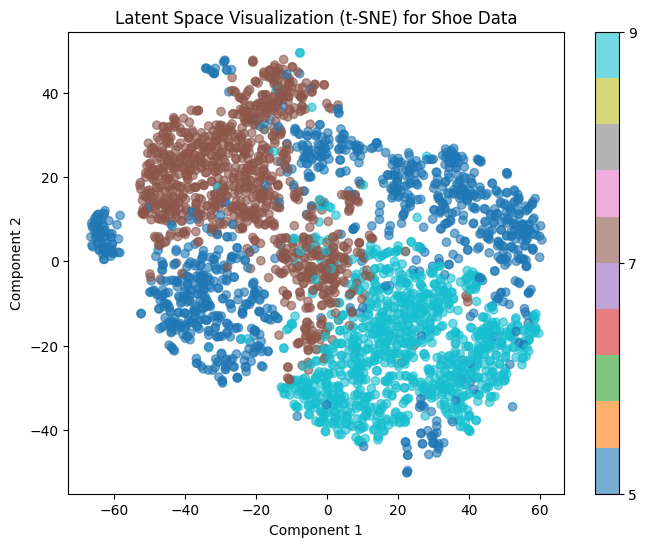

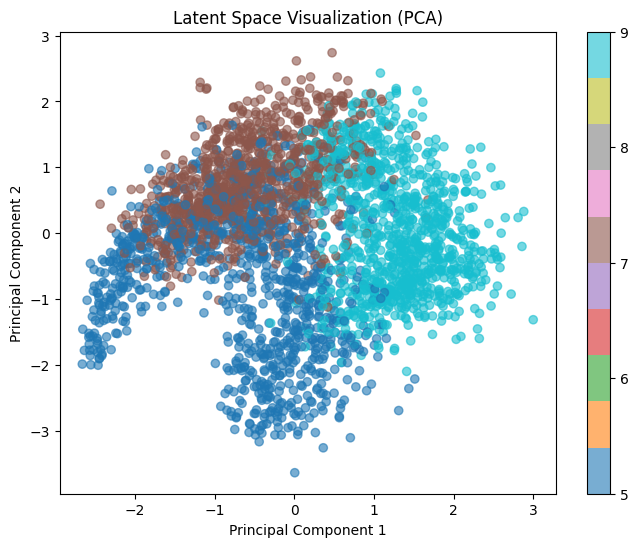

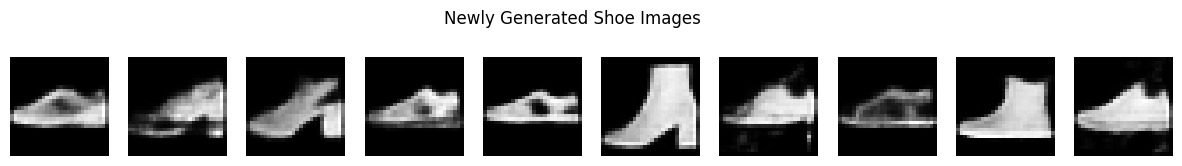

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Custom dataset filter: only include shoe related images (Sandal, Sneaker, Ankle boot)
def get_shoes_subset(dataset, shoe_labels=[5, 7, 9]):
    indices = [i for i, (_, label) in enumerate(dataset) if label in shoe_labels]
    return Subset(dataset, indices)

# Define the VAE model for FashionMNIST with enhanced CNN layers
class VAE_Fashion(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE_Fashion, self).__init__()
        self.latent_dim = latent_dim
        # --- Encoder ---
        # Input: (batch, 1, 28, 28)
        self.enc_conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)   # -> (batch, 64, 14, 14)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # -> (batch, 128, 7, 7)
        # Flatten output to feed into linear layers
        self.fc_mu = nn.Linear(128 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(128 * 7 * 7, latent_dim)
        
        # --- Decoder ---
        # Transform latent vector to feature map
        self.fc_dec = nn.Linear(latent_dim, 128 * 7 * 7)
        # Decoder uses ConvTranspose2d layers
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # -> (batch, 64, 14, 14)
        self.dec_conv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)    # -> (batch, 1, 28, 28)
    
    def encode(self, x):
        h1 = F.relu(self.enc_conv1(x))
        h2 = F.relu(self.enc_conv2(h1))
        h2_flat = h2.view(x.size(0), -1)
        mu = self.fc_mu(h2_flat)
        logvar = self.fc_logvar(h2_flat)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc_dec(z))
        h3 = h3.view(-1, 128, 7, 7)
        h4 = F.relu(self.dec_conv1(h3))
        recon_x = torch.sigmoid(self.dec_conv2(h4))
        return recon_x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function: Binary Cross-Entropy loss plus KL divergence
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

# Training loop for the VAE
def train(model, train_loader, optimizer, device, epochs=100):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        avg_loss = train_loss / len(train_loader.dataset)
        print(f'Epoch: {epoch+1} Average loss: {avg_loss:.4f}')

# Visualize latent space using t-SNE
def visualize_latent_space(model, test_loader, device):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=[5, 7, 9])
    plt.title("Latent Space Visualization (t-SNE) for Shoe Data")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Generate and display new images from the latent space
def generate_images(model, device, num_images=10):
    model.eval()
    with torch.no_grad():
        # Sample latent vectors from standard normal distribution
        z = torch.randn(num_images, model.latent_dim).to(device)
        samples = model.decode(z).cpu()
    
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*1.5, 2))
    for i in range(num_images):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Newly Generated Shoe Images")
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    # Filter the datasets to include only shoe-related data (labels 5, 7, 9)
    train_dataset = get_shoes_subset(train_dataset, shoe_labels=[5, 7, 9])
    test_dataset = get_shoes_subset(test_dataset, shoe_labels=[5, 7, 9])
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    model = VAE_Fashion(latent_dim=20).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    print("Training VAE_Fashion on shoe data...")
    train(model, train_loader, optimizer, device, epochs=100)
    
    # Visualize the latent space using t-SNE
    visualize_latent_space(model, test_loader, device)
    PCA_visualization(model, test_loader, device)

    
    
    # Generate and display 10 new images
    generate_images(model, device, num_images=10)
    
if __name__ == '__main__':
    main()

In [4]:
def PCA_visualization(model, test_loader, device):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
            labels.append(target.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    # Reduce dimensions to 2 using PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latents)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Latent Space Visualization (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

## PART - 5

Training VAE on normal sensor data...
Epoch 1/100, Loss: 20.0495
Epoch 2/100, Loss: 19.9768
Epoch 3/100, Loss: 19.8960
Epoch 4/100, Loss: 19.7597
Epoch 5/100, Loss: 19.5854
Epoch 6/100, Loss: 19.4694
Epoch 7/100, Loss: 19.3517
Epoch 8/100, Loss: 19.2685
Epoch 9/100, Loss: 19.2069
Epoch 10/100, Loss: 19.1448
Epoch 11/100, Loss: 19.1531
Epoch 12/100, Loss: 19.0750
Epoch 13/100, Loss: 19.0096
Epoch 14/100, Loss: 18.9685
Epoch 15/100, Loss: 18.8868
Epoch 16/100, Loss: 18.8195
Epoch 17/100, Loss: 18.7927
Epoch 18/100, Loss: 18.7564
Epoch 19/100, Loss: 18.7207
Epoch 20/100, Loss: 18.7142
Epoch 21/100, Loss: 18.6551
Epoch 22/100, Loss: 18.6164
Epoch 23/100, Loss: 18.6279
Epoch 24/100, Loss: 18.6356
Epoch 25/100, Loss: 18.6017
Epoch 26/100, Loss: 18.5704
Epoch 27/100, Loss: 18.5002
Epoch 28/100, Loss: 18.5505
Epoch 29/100, Loss: 18.5202
Epoch 30/100, Loss: 18.4670
Epoch 31/100, Loss: 18.4554
Epoch 32/100, Loss: 18.4080
Epoch 33/100, Loss: 18.4468
Epoch 34/100, Loss: 18.4281
Epoch 35/100, Loss:

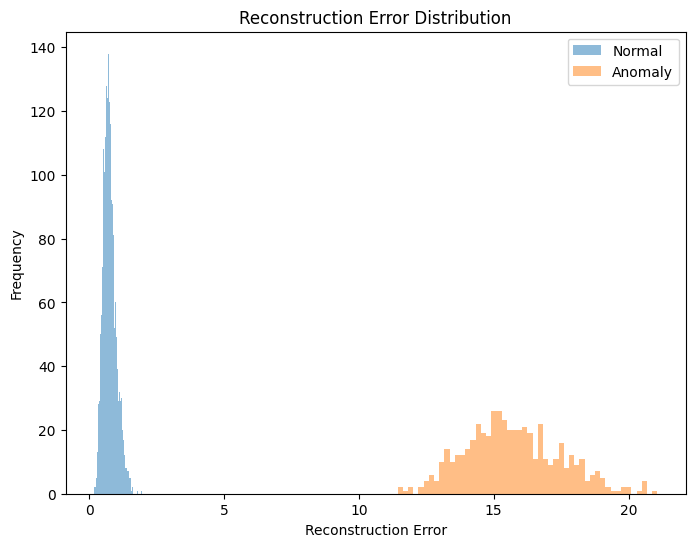

Visualizing latent space using t-SNE...


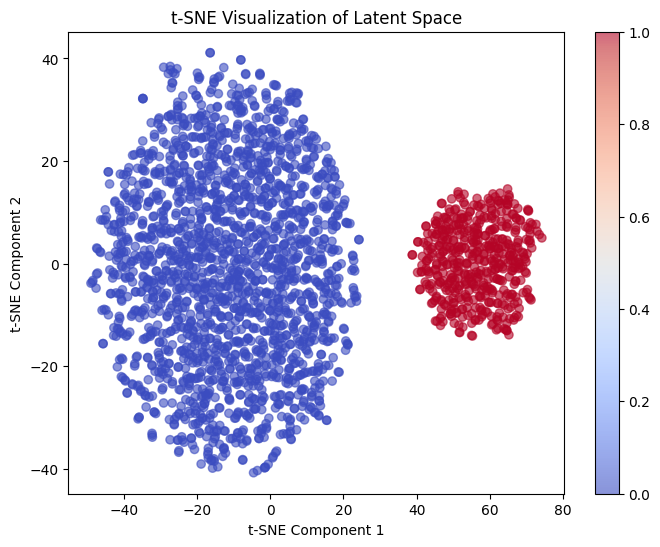

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------------------------------
# Synthetic Sensor Dataset
# -------------------------------
class SensorDataset(Dataset):
    def __init__(self, data, labels):
        # data: numpy array of shape (num_samples, num_features)
        # labels: 0 for normal, 1 for anomaly
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.int64)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------------
# VAE Model (Fully Connected Network)
# -------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64, latent_dim=10):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return self.fc5(h4)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# -------------------------------
# Loss Function: MSE + KL Divergence
# -------------------------------
def loss_function(recon_x, x, mu, logvar):
    # Use MSE loss for continuous sensor data
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KL

# -------------------------------
# Training Function
# -------------------------------
def train(model, dataloader, optimizer, device, epochs=100):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_data, _ in dataloader:
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch_data)
            loss = loss_function(recon, batch_data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        avg_loss = train_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# -------------------------------
# Evaluation: Compute Reconstruction Error
# -------------------------------
def evaluate(model, dataloader, device):
    model.eval()
    all_errors = []
    all_labels = []
    with torch.no_grad():
        for batch_data, labels in dataloader:
            batch_data = batch_data.to(device)
            recon, mu, logvar = model(batch_data)
            # Compute per-sample mean squared error
            errors = F.mse_loss(recon, batch_data, reduction='none')
            errors = errors.mean(dim=1)
            all_errors.append(errors.cpu().numpy())
            all_labels.append(labels)
    all_errors = np.concatenate(all_errors)
    all_labels = np.concatenate(all_labels)
    return all_errors, all_labels

# -------------------------------
# Plot Error Distribution
# -------------------------------
def plot_errors(errors, labels):
    plt.figure(figsize=(8, 6))
    plt.hist(errors[labels == 0], bins=50, alpha=0.5, label='Normal')
    plt.hist(errors[labels == 1], bins=50, alpha=0.5, label='Anomaly')
    plt.legend()
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()

# -------------------------------
# Visualize Latent Space using t-SNE
# -------------------------------
def visualize_latent_space(model, dataloader, device):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(device)
            mu, _ = model.encode(batch_data)
            latents.append(mu.cpu().numpy())
            labels.append(batch_labels.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latents)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Latent Space")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Simulate synthetic sensor data
    num_features = 20
    num_normal = 10000  # total normal samples
    num_anomaly = 500   # anomalous samples

    # Normal sensor readings (simulate typical behavior)
    normal_data = np.random.normal(0, 1, size=(num_normal, num_features))
    # Anomalous readings (simulate abnormal behavior with a shift in the mean)
    anomaly_data = np.random.normal(5, 1, size=(num_anomaly, num_features))
    
    # Label 0 = normal, 1 = anomaly
    normal_labels = np.zeros(num_normal)
    anomaly_labels = np.ones(num_anomaly)
    
    # Split data: Train on normal samples only
    train_data = normal_data[:8000]
    train_labels = normal_labels[:8000]
    
    # Test set: Remaining normal samples + all anomaly samples
    test_normal_data = normal_data[8000:]
    test_normal_labels = normal_labels[8000:]
    test_data = np.concatenate([test_normal_data, anomaly_data], axis=0)
    test_labels = np.concatenate([test_normal_labels, anomaly_labels], axis=0)
    
    # Create dataset objects and DataLoaders
    train_dataset = SensorDataset(train_data, train_labels)
    test_dataset = SensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize VAE model, optimizer, and device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(input_dim=num_features, hidden_dim=64, latent_dim=10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    print("Training VAE on normal sensor data...")
    train(model, train_loader, optimizer, device, epochs=100)
    
    print("Evaluating reconstruction errors on test data...")
    errors, labels = evaluate(model, test_loader, device)
    plot_errors(errors, labels)
    
    print("Visualizing latent space using t-SNE...")
    visualize_latent_space(model, test_loader, device)

if __name__ == '__main__':
    main()


Training VAE on normal network traffic...
Epoch 1/50 Loss: 56.1401
Epoch 2/50 Loss: 40.1810
Epoch 3/50 Loss: 33.1423
Epoch 4/50 Loss: 29.7205
Epoch 5/50 Loss: 27.2146
Epoch 6/50 Loss: 25.7386
Epoch 7/50 Loss: 25.6545
Epoch 8/50 Loss: 24.5272
Epoch 9/50 Loss: 23.2451
Epoch 10/50 Loss: 22.2607
Epoch 11/50 Loss: 21.6997
Epoch 12/50 Loss: 20.5097
Epoch 13/50 Loss: 19.6316
Epoch 14/50 Loss: 19.8094
Epoch 15/50 Loss: 18.4229
Epoch 16/50 Loss: 17.8726
Epoch 17/50 Loss: 17.4226
Epoch 18/50 Loss: 16.7892
Epoch 19/50 Loss: 16.4757
Epoch 20/50 Loss: 16.1717
Epoch 21/50 Loss: 16.7033
Epoch 22/50 Loss: 15.3455
Epoch 23/50 Loss: 15.9172
Epoch 24/50 Loss: 16.4981
Epoch 25/50 Loss: 16.2622
Epoch 26/50 Loss: 14.7387
Epoch 27/50 Loss: 269.4208
Epoch 28/50 Loss: 19.6663
Epoch 29/50 Loss: 15.6045
Epoch 30/50 Loss: 14.7058
Epoch 31/50 Loss: 14.2073
Epoch 32/50 Loss: 14.1324
Epoch 33/50 Loss: 14.0325
Epoch 34/50 Loss: 13.9782
Epoch 35/50 Loss: 13.6438
Epoch 36/50 Loss: 13.7677
Epoch 37/50 Loss: 13.4642
Epoc

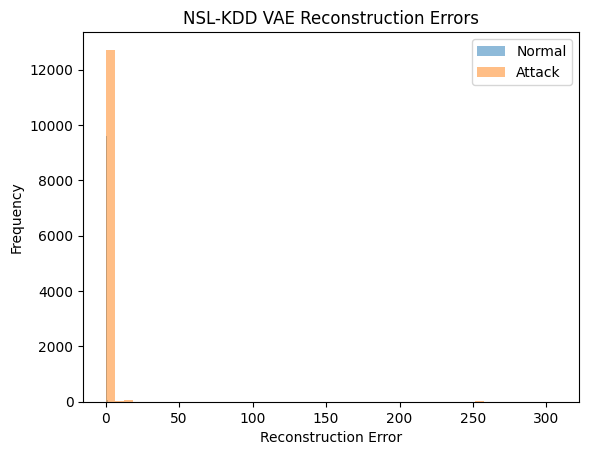

ROC AUC: 0.939369303294575


In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# -------------------------------
# Dataset for NSL-KDD (CSV Files)
# -------------------------------
class NSLKDDDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.int64)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# -------------------------------
# VAE Model (Fully Connected)
# -------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=16):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return self.fc5(h4)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# -------------------------------
# Loss Function: MSE + KL Divergence
# -------------------------------
def loss_function(recon_x, x, mu, logvar):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return mse + kl

# -------------------------------
# Training Function
# -------------------------------
def train_vae(model, dataloader, optimizer, device, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(batch_x)
            loss = loss_function(recon, batch_x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")

# -------------------------------
# Evaluation Function
# -------------------------------
def evaluate_vae(model, dataloader, device):
    model.eval()
    errors = []
    all_labels = []
    with torch.no_grad():
        for batch_x, labels in dataloader:
            batch_x = batch_x.to(device)
            recon, mu, logvar = model(batch_x)
            batch_err = F.mse_loss(recon, batch_x, reduction='none').mean(dim=1)
            errors.append(batch_err.cpu().numpy())
            all_labels.append(labels.numpy())
    errors = np.concatenate(errors)
    all_labels = np.concatenate(all_labels)
    return errors, all_labels

# -------------------------------
# Main Function
# -------------------------------
def main():
    # Assign column names for 43 columns.
    col_names = [f"col_{i}" for i in range(1, 44)]
    
    # Load NSL-KDD CSV files (e.g., KDDTrain+.TXT and KDDTest+.TXT).
    # Adjust file paths as needed.
    train_df = pd.read_csv("/home/taha/Downloads/archive(1)/KDDTrain+.txt", header=None, names=col_names)
    test_df  = pd.read_csv("/home/taha/Downloads/archive(1)/KDDTest+.txt", header=None, names=col_names)
    
    # Features: columns 1 to 41 (index 0 to 40).
    features_train = train_df.iloc[:, :41]
    features_test  = test_df.iloc[:, :41]
    
    # Convert categorical columns (col_2, col_3, col_4) using one-hot encoding.
    features_train = pd.get_dummies(features_train, columns=["col_2", "col_3", "col_4"])
    features_test  = pd.get_dummies(features_test, columns=["col_2", "col_3", "col_4"])
    
    # Ensure both train and test have the same columns (fill missing ones with 0).
    features_train, features_test = features_train.align(features_test, join='outer', axis=1, fill_value=0)
    
    # Labels: use column 42 (index 41) which contains attack-type.
    # Map "normal" to 0 and any other attack to 1.
    y_train = train_df["col_42"].apply(lambda x: 0 if x.strip() == "normal" else 1).values
    y_test  = test_df["col_42"].apply(lambda x: 0 if x.strip() == "normal" else 1).values
    
    # Standardize the features.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(features_train.values)
    X_test  = scaler.transform(features_test.values)
    
    # Train the VAE only on normal data (label == 0)
    normal_idx = np.where(y_train == 0)[0]
    X_train_norm = X_train[normal_idx]
    y_train_norm = y_train[normal_idx]
    
    train_dataset = NSLKDDDataset(X_train_norm, y_train_norm)
    test_dataset  = NSLKDDDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train.shape[1]
    model = VAE(input_dim=input_dim, hidden_dim=64, latent_dim=16).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    print("Training VAE on normal network traffic...")
    train_vae(model, train_loader, optimizer, device, epochs=50)
    
    print("Evaluating model...")
    errors, labels = evaluate_vae(model, test_loader, device)
    
    # Plot reconstruction error distribution for normal vs. attack samples.
    plt.hist(errors[labels == 0], bins=50, alpha=0.5, label='Normal')
    plt.hist(errors[labels == 1], bins=50, alpha=0.5, label='Attack')
    plt.legend()
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.title("NSL-KDD VAE Reconstruction Errors")
    plt.show()
    
    # Compute and print ROC AUC.
    auc = roc_auc_score(labels, errors)
    print("ROC AUC:", auc)

if __name__ == '__main__':
    main()
